In [374]:
#| code-summary: Imports and model evaluation function
#| output: false
#| echo: false
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, functools, itertools, collections
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from einops import rearrange

for d in ['data', 'models', 'logs']: os.makedirs(d, exist_ok = True)
DATA_DIR = '../data'

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        print('Setting seed for CUDA')
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()
device

device(type='mps')

# Idea

This classic paper introduced *distillation* as a way of transferring knowledge from a big network teacher into a small one. The core observation is that we should use the big model's output distribution as soft labels to train the small model. 

Remember that in classification we measure the [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) loss, given the predicted $\hat y_c$ and correct $y_c$ class probabilities of an example, with:

$$
L(\hat y,y) = -\sum_c y_c \log \hat y_c
$$

To use soft labels we just set $y = f_{\text{big}}(x)$.

These soft labels provide a much richer training signal for the smaller model, especially when the larger model distributes its probability mass across multiple classes (i.e. when the labels have high entropy). To force this high entropy, the authors propose increasing the temperature $T$ of the softmax layer in the larger model to produce the soft labels. The small model trains with this same temperature but then sets it to 1 during testing.

![Increasing the temperature of the big model produces softer and more informative labels.](images/demo.png)

They also had better results by adding a small term to the loss function with the regular hard-labeled cross-entropy. The reasoning is that the model may not have enough capacity to learn the soft targets, so *"erring in the direction of the correct answer turns out to be helpful"*. If we write the output of a model with temperature $T$ as $f(x; T)$, then the complete loss is

$$
L_{\text{distill}}(x,y) = a T^2 \cdot L\left[ f_{\text{small}}(x; T), f_{\text{big}}(x; T) \right] + (1-a) \cdot L \left [ f_{\text{small}}(x; 1), y \right ]
$$

The first term is scaled by $T^2$ because the magnitudes of the gradients scale as $T^{-2}$ and we want to control the contribution of each term by changing only $a$.

::: {.callout-note collapse="true" title="Why do the gradient magnitudes scale as $T^{-2}$?" icon=false}

Let $z$ be the logits, then the output $i$th entry of the softmax layer with temperature $T$ is
$$
\sigma_T(z)_i = \frac{e^{z_i/T}}{\sum_j e^{z_j/T}} = \hat y_i
$$
Plugging into the loss
$$
L(\hat y, y) = -\sum_i y_i \log \left(\frac{e^{z_i/T}}{\sum_j e^{z_j/T}} \right) = -\frac{1}{T}\sum_i y_i z_i + (1) \log \left( \sum_j e^{z_j/T} \right)
$$
and differentiating w.r.t. $z_i$ (don't forget the chain rule), we get
$$
\frac{\partial L}{\partial z_i} = -\frac{1}{T} y_i + \frac{1}{ \sum_j e^{z_j/T}} \times e^{z_i/T} (1/T) = \frac{1}{T}(\sigma_T(z)_i - y_i)
$$
So, we see that
$$
|| \nabla L||_2^2 = \frac{1}{T^2} \sum_i (\sigma_T(z)_i - y_i)^2 \propto L^{-2}
$$
:::

# MNIST

We try out distillation on the small-scale MNIST experiment that the authors describe. They use a two-layer linear ReLU architecture with dropout, a jitter image augmentation, and max norm as regularization.

In [114]:
#| code-summary: Helper functions
#| echo: false
class RandomJitter(object):
    def __init__(self, pixels=2):
        self.pixels = pixels
        
    def __call__(self, img):
        dx = np.random.randint(-self.pixels, self.pixels + 1)
        dy = np.random.randint(-self.pixels, self.pixels + 1)
        return transforms.functional.affine(img, angle=0, translate=(dx, dy), 
                                         scale=1.0, shear=0)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.early_stop
    
def evaluate_model(model, data_loader, criterion = nn.CrossEntropyLoss()):
    model.eval()

    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(data_loader), correct / total

def save_results(model, history, name):
    torch.save(model.state_dict(), f'models/{name}.pt')
    pd.DataFrame(history).to_csv(f'logs/{name}.csv', index = False)

In [51]:
#| code-summary: Model definition
class Model(nn.Module):
    '''
    Used in MNIST experiments.
    A two-layer linear ReLU network with dropout and max norm regularization.
    '''
    def __init__(self, hidden_size, max_norm = 2.0, drop_rate = 0.5):
        super(Model, self).__init__()
        self.max_norm = max_norm
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        # Clip the weights to the maximum allowed norm
        if self.max_norm is not None:
            with torch.no_grad():
                for layer in self.modules():
                    if isinstance(layer, nn.Linear):
                        norm = layer.weight.data.norm(2, dim=1, keepdim=True)
                        desired = torch.clamp(norm, max=self.max_norm)
                        layer.weight.data *= (desired / norm)
                    
        return self.layers(x)

In [417]:
#| code-summary: Data loading
#| echo: false
reg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

aug_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomJitter(pixels = 2),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root = DATA_DIR, train = True,  download = True, transform = aug_transform)
test_dataset  = datasets.MNIST(root = DATA_DIR, train = False, download = True, transform = reg_transform)

# Split training data into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)


We define the distillation loss:

In [329]:
#| code-summary: Define training losses
#| code-fold: show
# Regular cross-entropy loss
def hard_loss(outputs, labels, criterion, *args):
    return criterion(outputs, labels)

# Distillation loss
def soft_loss(outputs, labels, criterion, examples, big_model, T, a):
    with torch.no_grad():
        big_model.eval()
        soft_labels = F.softmax(big_model(examples) / T, dim = 1)

    return a * (T ** 2) * criterion(outputs / T, soft_labels) + (1 - a) * criterion(outputs, labels)

In [322]:
#| echo: false
def train(model, loss_func, train_loader, val_loader, num_epochs, lr, patience):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
    early_stopping = EarlyStopping(patience = patience)
    history = collections.defaultdict(list)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_func(outputs, labels, criterion, images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'epoch: {epoch+1}/{num_epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
        
        if early_stopping(val_loss): break

    return history

The hidden dimensions of the big and small networks are 1200 and 800 respectively. 
To train the networks we use an early stopping validation set and choose $T = 4.0$ and $a = 0.5$ (since the authors don't mention their values).

In [291]:
#| code-summary: Train the big model
#| output: false
# Hyperparameters
num_epochs = 100
batch_size = 128
lr = 0.01
patience = 7
big_model_size = 1200
small_model_size = 800

loader = lambda ds, shuffle = False: DataLoader(ds, batch_size = batch_size, shuffle = shuffle)
val_loader   = loader(val_dataset)
test_loader  = loader(test_dataset)

# Train the big model
train_dataset.dataset.transform = aug_transform
train_loader = loader(train_dataset, shuffle = True)

big_model = Model(1200).to(device)
big_train_history = train(big_model, hard_loss, train_loader, val_loader, num_epochs, lr, patience)
test_loss, test_accuracy = evaluate_model(big_model, test_loader)

save_results(big_model, big_train_history, 'big_model')
test_loss, test_accuracy

In [434]:
#| code-summary: Train the smaller model on hard labels
#| output: false
def train_small_model(train_dataset, val_dataset, seed, loss, model_size = small_model_size):
    set_seed(seed)
    # no augmentation
    train_dataset.dataset.transform = reg_transform
    train_loader = loader(train_dataset, shuffle = True)
    val_loader = loader(val_dataset)

    # or regularization
    small_model = Model(model_size, max_norm = None, drop_rate = 0.0).to(device)
    small_train_history = train(small_model, loss, train_loader, val_loader, num_epochs, lr, patience)
    return small_model, small_train_history

# small_model, small_train_history = train_small_model(train_dataset, val_dataset, seed = 42, loss = hard_loss, T = 1.0)
# save_results(small_model, small_train_history, 'small_model')
# evaluate_model(small_model, test_loader)

In [ ]:
#| code-summary: Train the distilled model
#| output: false
temperature, a = 4.0, 0.5

distilled_model, distilled_train_history = train_small_model(
    train_dataset = train_dataset, val_dataset = val_dataset, seed = 42,
    loss = functools.partial(soft_loss, big_model = big_model, T = temperature, a = a)
)
save_results(distilled_model, distilled_train_history, 'distilled_model')
evaluate_model(distilled_model, test_loader)

epoch: 1/100, train_loss: 10.0936, val_loss: 0.1055, val_accuracy: 0.9673
epoch: 2/100, train_loss: 9.0607, val_loss: 0.0739, val_accuracy: 0.9755
epoch: 3/100, train_loss: 8.9822, val_loss: 0.0632, val_accuracy: 0.9813
epoch: 4/100, train_loss: 8.9506, val_loss: 0.0600, val_accuracy: 0.9807
epoch: 5/100, train_loss: 8.9331, val_loss: 0.0561, val_accuracy: 0.9827
epoch: 6/100, train_loss: 8.9222, val_loss: 0.0570, val_accuracy: 0.9830
epoch: 7/100, train_loss: 8.9151, val_loss: 0.0535, val_accuracy: 0.9840
epoch: 8/100, train_loss: 8.9089, val_loss: 0.0526, val_accuracy: 0.9840
epoch: 9/100, train_loss: 8.9048, val_loss: 0.0519, val_accuracy: 0.9840
epoch: 10/100, train_loss: 8.9015, val_loss: 0.0519, val_accuracy: 0.9843
epoch: 11/100, train_loss: 8.8989, val_loss: 0.0508, val_accuracy: 0.9848
epoch: 12/100, train_loss: 8.8966, val_loss: 0.0505, val_accuracy: 0.9852
epoch: 13/100, train_loss: 8.8951, val_loss: 0.0496, val_accuracy: 0.9855
epoch: 14/100, train_loss: 8.8933, val_loss: 0

(0.033212841342349204, 0.9891)

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_76611/4017433887.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/big

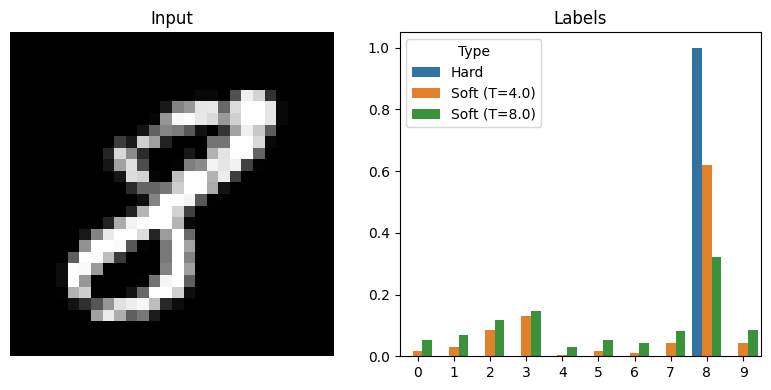

In [454]:
#| echo: false
#| output: false
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

# plot an example in the fist ax
idx = 9694
img, label = test_dataset[idx]
ax1.imshow(img.squeeze().numpy(), cmap = 'gray')
ax1.axis('off')
ax1.set_title(f'Input')

# ax2: the predicted distribution and hard label
# Load the big model and get the output
model = Model(big_model_size).to(device)
model.load_state_dict(torch.load('models/big_model.pt'))
model.eval()
get_probs = lambda o, T: F.softmax(o / T, dim = 1)[0].cpu().numpy()
with torch.no_grad():
    output = model(img.to(device)[None, :])

# Prepare data for seaborn
data = pd.DataFrame({
    'Class': list(range(10)) * 3,
    'Probability': [1.0 if i == label else 0.0 for i in range(10)] + list(get_probs(output, 4.0)) + list(get_probs(output, 8.0)),
    'Type': ['Hard'] * 10 + ['Soft (T=4.0)'] * 10 + ['Soft (T=8.0)'] * 10
})

# Plot with seaborn
sns.barplot(x='Class', y='Probability', hue='Type', data=data, ax=ax2)
ax2.set_ylabel(''); ax2.set_xlabel('')
# ax2.set_xticks(range(10))
ax2.set_title(f'Labels')

f.tight_layout()
f.savefig('images/demo.png')

And get the following test accuracies:

In [379]:
#| echo: false
names = ['big_model', 'small_model', 'distilled_model']
res = []
for model_name in names:
    model = Model(big_model_size if 'big' in model_name else small_model_size).to(device)
    model.load_state_dict(torch.load(f'models/{model_name}.pt'))
    model.eval()
    _, test_accuracy = evaluate_model(model, test_loader)
    res.append(f'{model_name.split("_")[0]}: {test_accuracy:.4f}')

print(', '.join(res))

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_76611/2388879164.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{mo

big: 0.9901, small: 0.9833, distilled: 0.9891


# Mystical 3

The authors then remove 3 from the transfer set the distilled model is trained on to test its generalization to unseen classes. *"So from the perspective
of the distilled model, 3 is a mythical digit that it has never seen*". When we evaluate on the test set, which still contains 3s, we see that the distilled model performs much better than a small model trained with hard labels:

In [ ]:
#| code-summary: Train without 3s in transfer set
#| output: false

# Remove all 3s from the dataset
train_dataset = datasets.MNIST(root = DATA_DIR, train = True,  download = True, transform = aug_transform)
train_dataset = torch.utils.data.Subset(train_dataset, np.where(train_dataset.targets != 3)[0])

# Split training data into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Train small without distillation
small_no_3, small_no_3_history = train_small_model(
    train_dataset = train_dataset, val_dataset = val_dataset,
    seed = 42, loss = hard_loss, model_size = 800
)

# Train small with distillation
distilled_no_3, distilled_no_3_history = train_small_model(
    train_dataset = train_dataset, val_dataset = val_dataset,
    seed = 42, loss = functools.partial(soft_loss, big_model = big_model, T = 4.0, a = 0.5),
    model_size = 800
)

In [ ]:
#| code-summary: Eval models
#| echo: false
model = Model(800).to(device)
model.load_state_dict(torch.load('models/small_no_3.pt'))
model.eval()
_, not_dist_acc = evaluate_model(model, test_loader)

model = Model(800).to(device)
model.load_state_dict(torch.load('models/distilled_no_3.pt'))
model.eval()
_, dist_acc = evaluate_model(model, test_loader)

print(f'small: {not_dist_acc:.4f}, distilled: {dist_acc:.4f}')

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_76611/1087436920.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/smal

Not distilled: 0.8882, distilled: 0.9869


In the paper, the authors take it to the extreme and show that a distilled model trained only on 7 and 8 still achieves impressive performance. They also do experiments on a bigger speech recognition dataset and discuss training experts on a CV dataset with distillation from a generalist model as regularization.

# Final thoughts

It was very fun to return to this classic paper. It introduced a simple yet powerful idea that is still widely used today. Like most of these papers (circa 2015), it is very clear and readable. And—as Hinton staple—it is slightly bio-inspired, in this case by larvae.

Some pointers to papers that extended on this idea. [Self-distillation](https://arxiv.org/abs/1805.04770) makes the teacher ("big") and student ("small") models the same size, and in [mutual learning](https://arxiv.org/abs/1706.00384) two or more networks learn collaboratively. However, the main extensions of this paper build on its main theme: train on a richer signal. You might train the student to imitate the teacher's [intermediate](https://arxiv.org/abs/1412.6550) (or [last](https://openreview.net/forum?id=ZzwDy_wiWv)) representations, [attention maps](https://arxiv.org/abs/1612.03928), etc.